<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/Model_Selector_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === IMPORTS ===
import os
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# === MOUNT GOOGLE DRIVE ===
drive.mount('/content/drive')

# === CONFIGURATION ===
results_dir = "/content/drive/MyDrive/Model_Selector/Results"
model_files = [
    "ppo_model_selector_ready.csv",
    "rf_model_selector_ready.csv",
    "kmeans_model_selector_ready.csv"
]
combined_output_path = os.path.join(results_dir, "all_models_selector_ready.csv")
output_path = os.path.join(results_dir, "best_models_by_ticker.xlsx")

# === STEP 1: COMBINE ALL MODEL FILES ===
combined_results = []

for file in model_files:
    file_path = os.path.join(results_dir, file)
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            model_name = file.split("_model_selector")[0].upper()
            df["Model"] = model_name
            combined_results.append(df)
            print(f"✅ Loaded: {file_path}")
        except Exception as e:
            print(f"⚠️ Error reading {file_path}: {e}")
    else:
        print(f"❌ File not found: {file_path}")

if not combined_results:
    raise ValueError("❌ No valid model files loaded.")

# === STEP 2: SAVE COMBINED FILE ===
master_df = pd.concat(combined_results, ignore_index=True)
master_df.to_csv(combined_output_path, index=False)
print(f"\n✅ Combined model selector results saved to:\n{combined_output_path}")

# === STEP 3: CLEANUP & SCORING ===
df = master_df.copy()
print(f"\n📊 Combined results shape: {df.shape}")

# Fix 'Signal Map' if stored as string
if 'Signal Map' in df.columns:
    df['Signal Map'] = df['Signal Map'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("{") else x
    )

# Drop old lowercase 'score' column if present
if 'score' in df.columns:
    print("⚠️ Removing old 'score' column to avoid confusion.")
    df.drop(columns=['score'], inplace=True)

# Ensure numeric columns
for col in ['Sharpe', 'Return', 'Accuracy']:
    df[col] = pd.to_numeric(df.get(col), errors='coerce').fillna(0)

# Drop rows missing essential info
df = df[df['Ticker'].notnull() & df['Model'].notnull()]
df = df[df['Sharpe'].notna() & df['Return'].notna()]

# === STEP 4: COMPUTE COMPOSITE SCORE ===
df['Score'] = (
    df['Sharpe'] * 0.4 +
    df['Return'] * 0.3 +
    df['Accuracy'] * 0.3
)

# === STEP 5: SELECT BEST MODEL PER TICKER ===
best_models = df.sort_values(['Ticker', 'Score'], ascending=[True, False]) \
                .groupby('Ticker').first().reset_index()

# === STEP 6: SAVE TO EXCEL ===
best_models.to_excel(output_path, index=False)
print(f"\n✅ Saved best models by ticker to:\n{output_path}")

# === STEP 7: PRINT MODEL DISTRIBUTION AND TOP 10 ===
print("\n📊 Model win count:")
print(best_models['Model'].value_counts())

print("\n🏆 Top 10 by Score:")
display(best_models.sort_values('Score', ascending=False).head(10))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded: /content/drive/MyDrive/Model_Selector/Results/ppo_model_selector_ready.csv
✅ Loaded: /content/drive/MyDrive/Model_Selector/Results/rf_model_selector_ready.csv
✅ Loaded: /content/drive/MyDrive/Model_Selector/Results/kmeans_model_selector_ready.csv

✅ Combined model selector results saved to:
/content/drive/MyDrive/Model_Selector/Results/all_models_selector_ready.csv

📊 Combined results shape: (530, 15)
⚠️ Removing old 'score' column to avoid confusion.

✅ Saved best models by ticker to:
/content/drive/MyDrive/Model_Selector/Results/best_models_by_ticker.xlsx

📊 Model win count:
Model
RF     44
PPO     9
Name: count, dtype: int64

🏆 Top 10 by Score:


,Ticker,Model,Sharpe,Accuracy,Drawdown,Return,Final_Portfolio,Final Market,Final Strategy,Final Portfolio Value,Signal Map,Precision,Recall,F1_Score,Score
30,META,PPO,0.737,0.0000,18.71,190.34433,290344.33,1.352936,1.097718,0.133299,"{0: 'Buy', 1: 'Hold'}",NaN,NaN,NaN,57.398099
51,WMT,PPO,0.953,0.0000,11.84,110.85749,210857.49,1.535156,1.535156,0.454244,{1: 'Buy'},NaN,NaN,NaN,33.638447
20,IBM,PPO,0.701,0.0000,17.85,103.54472,203544.72,1.577773,1.307281,0.295814,"{1: 'Buy', 0: 'Hold'}",NaN,NaN,NaN,31.343816
7,AMZN,PPO,0.545,0.0000,20.97,95.78659,195786.59,1.119303,0.889341,-0.065344,"{0: 'Buy', 1: 'Hold'}",NaN,NaN,NaN,28.953977
8,AVGO,PPO,0.413,0.0000,25.76,76.66667,176666.67,1.618540,1.629724,0.623830,"{1: 'Buy', 0: 'Hold', 2: 'Sell'}",NaN,NaN,NaN,23.165201
41,QCOM,PPO,0.404,0.0000,34.43,66.73140,166731.40,0.789008,0.547862,-0.459537,"{1: 'Buy', 2: 'Hold'}",NaN,NaN,NaN,20.181020
0,AAPL,PPO,0.365,0.0000,17.32,39.95227,139952.27,1.112112,1.232698,0.289041,"{1: 'Buy', 2: 'Hold'}",NaN,NaN,NaN,12.131681
1,ABBV,PPO,0.340,0.0000,19.54,37.00056,137000.56,1.119311,1.192792,0.211109,"{2: 'Buy', 1: 'Hold', 0: 'Sell'}",NaN,NaN,NaN,11.236168
39,PG,PPO,0.250,0.0000,12.15,16.65642,116656.42,0.972715,0.971254,-0.011882,"{0: 'Buy', 1: 'Hold'}",NaN,NaN,NaN,5.096926
36,ORCL,RF,2.483,0.7143,0.25,1.57000,101574.81,1.313794,1.154067,0.468777,"{1: 'Buy', 2: 'Hold'}",NaN,NaN,NaN,1.678490


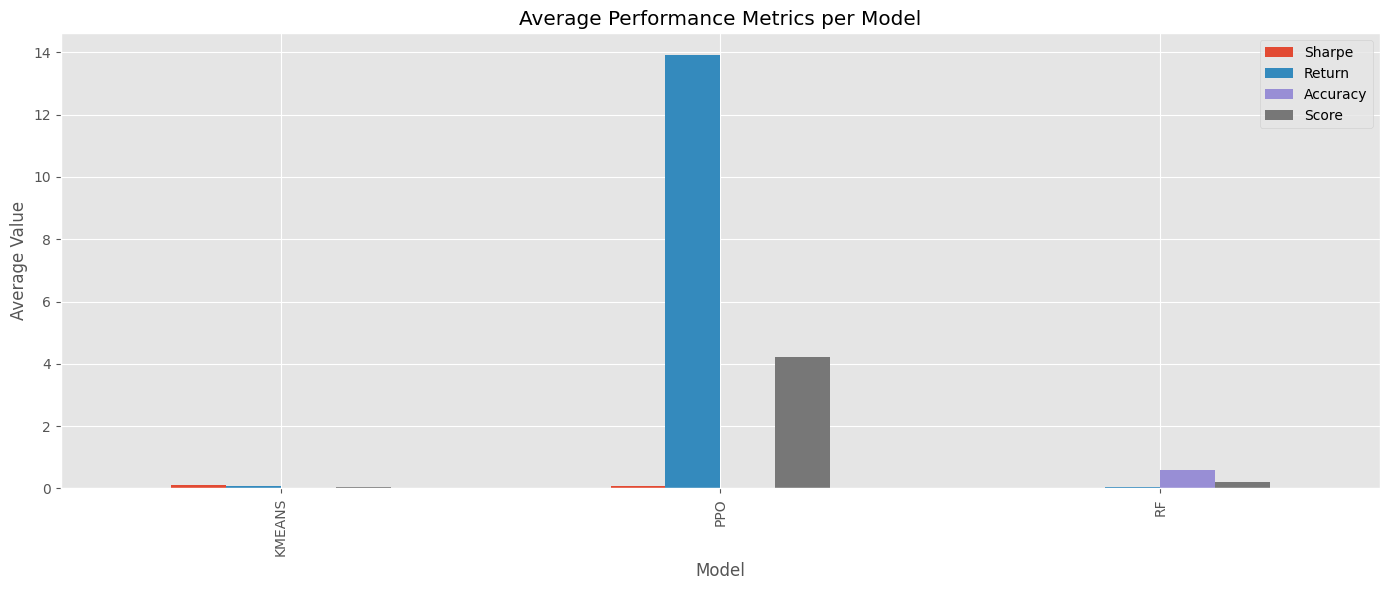

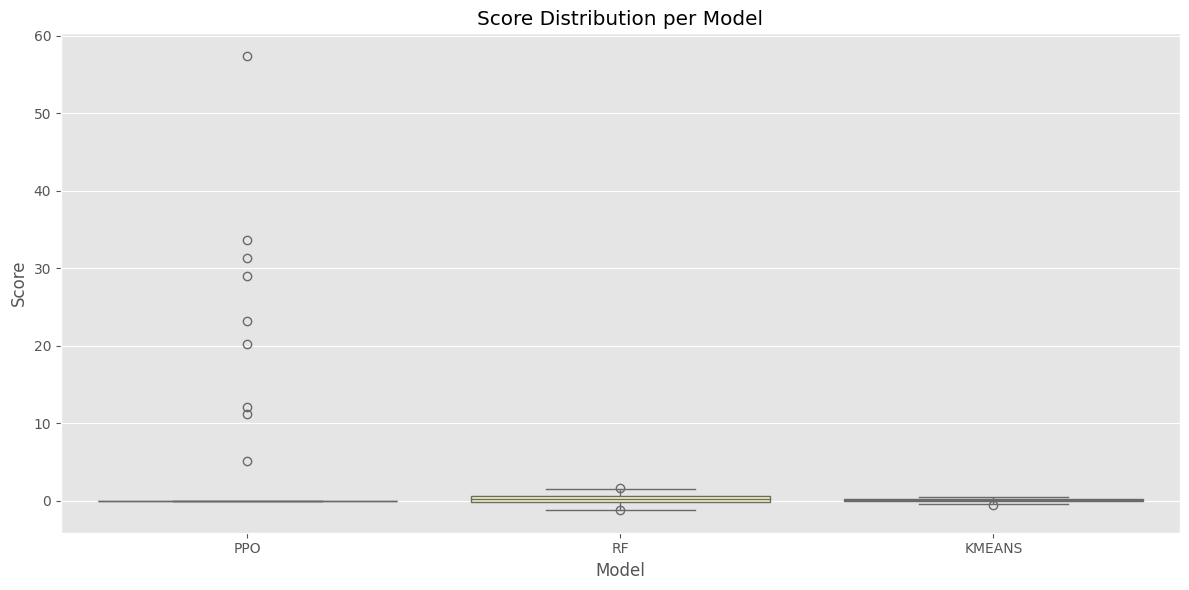

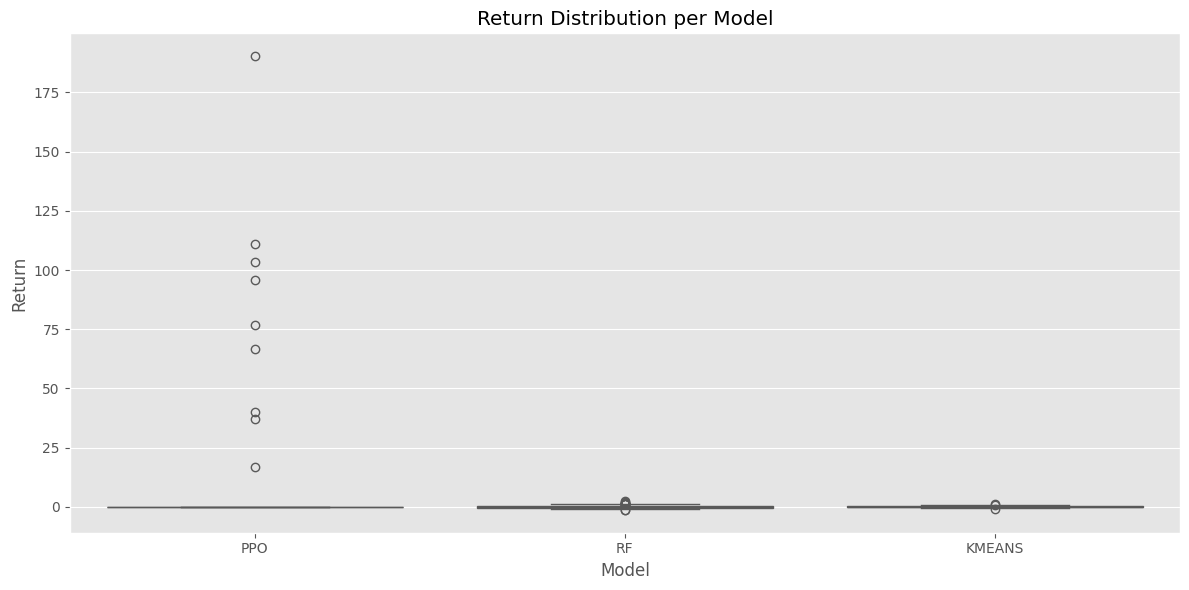

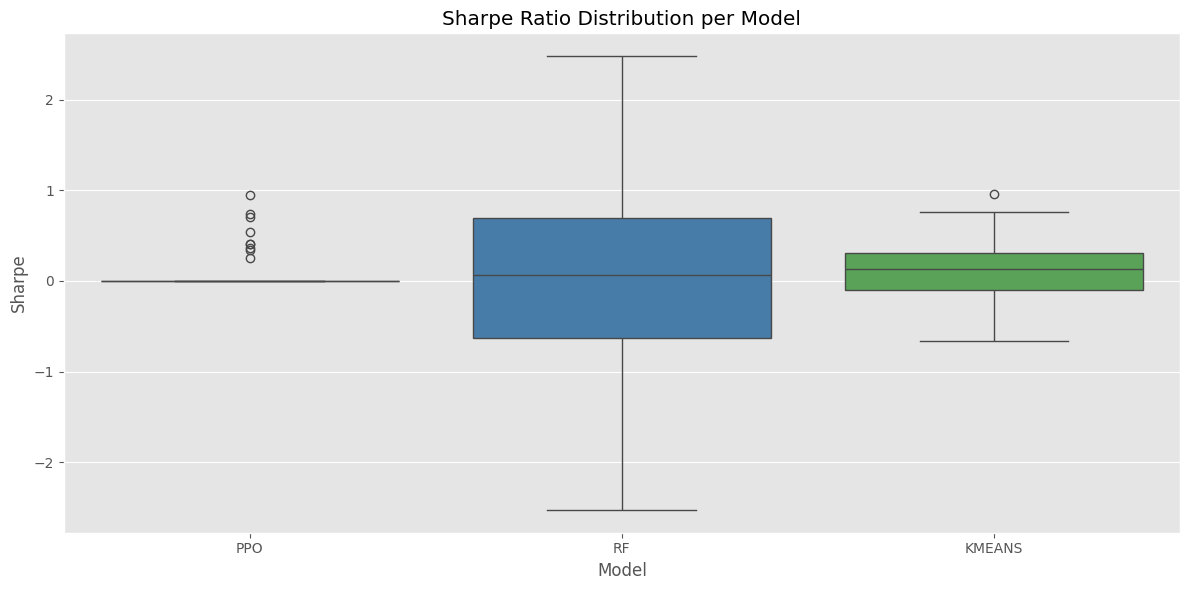

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure numeric in df (needed for plotting)
for col in ['Sharpe', 'Return', 'Accuracy', 'Score']:
    df[col] = pd.to_numeric(df.get(col), errors='coerce').fillna(0)


# === Plot 1: Average Performance Metrics per Model ===
plt.style.use("ggplot")  # Safe fallback style
model_means = df.groupby("Model")[['Sharpe', 'Return', 'Accuracy', 'Score']].mean()
model_means.plot(kind='bar', figsize=(14, 6), title="Average Performance Metrics per Model")
plt.ylabel("Average Value")
plt.tight_layout()
plt.show()

# === Plot 2: Score Distribution ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Score", hue="Model", palette="Set3", legend=False)
plt.title("Score Distribution per Model")
plt.tight_layout()
plt.show()

# === Plot 3: Return Distribution ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Return", hue="Model", palette="Set2", legend=False)
plt.title("Return Distribution per Model")
plt.tight_layout()
plt.show()

# === Plot 4: Sharpe Ratio Distribution ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Sharpe", hue="Model", palette="Set1", legend=False)
plt.title("Sharpe Ratio Distribution per Model")
plt.tight_layout()
plt.show()
